In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## IMPORTING LIBRARIES

In [ ]:
import pandas as pd 
import gensim
import numpy as np
import pandas as pd
import os
import re
import csv
import codecs
import sys
import pickle
from csv import DictReader

# from utils.dataset import DataSet
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,LSTM, Dense
from keras.models import Sequential
import nltk

nltk.download('punkt')
nltk.download('wordnet')



from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from numpy import zeros

from keras import callbacks
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense,Conv1D,MaxPooling1D, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional,Flatten
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
# import pydot
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf

from numpy import asarray
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from string import punctuation

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


##Pretrained Embedding vectors folder locations

In [ ]:
# Pretrained Embedding vectors folder locations
W2V_DIR = './data/GoogleNews-vectors-negative300.bin' # W2v
GloVe_DIR = './data/glove.6B.300d.txt' #Glove
FastTxt_DIR = './data/wiki-news-300d-1M.vec' #fasttext

## Config files

In [ ]:
MAX_SENT_LEN = 150    
MAX_VOCAB_SIZE = 40000 
LSTM_DIM = 256
EMBEDDING_DIM = 300 
BATCH_SIZE = 128

## DATASET function from the BASELINE MODEL

In [ ]:
class DataSet():
    def __init__(self, name="train", path="./data"):
        self.path = path

        print("Reading dataset")
        bodies = name+"_bodies.csv"
        stances = name+"_stances.csv"

        self.stances = self.read(stances)
        articles = self.read(bodies)
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])

        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))



    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows


In [ ]:
def generate_features(stances,dataset):
    h, b, y = [],[],[]
    LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
    for stance in stances:

        # print(stance['Stance'])
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])
   

    return(h,b,y)


In [ ]:
d=DataSet()
h,b,y= generate_features(d.stances,d)

combined_list = [list(x) for x in zip(h, b,y)]

combine_df_train=pd.DataFrame(combined_list,columns = ["Headline","articleBody","Stances"])
combine_df_train.to_csv("./data/combined_list_1.csv")



Reading dataset
Total stances: 49972
Total bodies: 1683


In [ ]:
competition_dataset = DataSet("competition_test")
h_test,b_test,y_test= generate_features(competition_dataset.stances,competition_dataset)

combined_list_test = [list(x_test) for x_test in zip(h_test, b_test, y_test)]

combine_df_test=pd.DataFrame(combined_list_test,columns = ["Headline","articleBody","Stances"])
combine_df_test.to_csv("./data/combined_list_test.csv")



Reading dataset
Total stances: 25413
Total bodies: 904


##Pre processing Steps

In [ ]:
# Pre-processing involves removal of puctuations and converting text to lower case
word_seq_head_train = [text_to_word_sequence(head) for head in combine_df_train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(body) for body in combine_df_train['articleBody']]
word_seq_head_test = [text_to_word_sequence(head) for head in combine_df_test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(body) for body in combine_df_test['articleBody']]

In [ ]:
# Combining all the words for head and body for the tokenizer
word_seq = []
for i in range(len(word_seq_head_train)):
    word_seq.append(word_seq_head_train[i])
for i in range(len(word_seq_bodies_train)):
    word_seq.append(word_seq_bodies_train[i])


# word_seq_test_1 = []
for i in range(len(word_seq_head_test)):
    word_seq.append(word_seq_head_test[i])
for i in range(len(word_seq_bodies_test)):
    word_seq.append(word_seq_bodies_test[i])

In [ ]:
# Removing special charaters

filter_list = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters=filter_list)
tokenizer.fit_on_texts([seq for seq in word_seq])

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 35978


In [ ]:
# Combine headline and body together
word_seq_train = [list(i) for i in word_seq_head_train]
for i in range(len(word_seq_head_train)):
    word_seq_train[i].extend(word_seq_bodies_train[i]) 
    
word_seq_test = [list(i) for i in word_seq_head_test]
for i in range(len(word_seq_head_test)):
    word_seq_test[i].extend(word_seq_bodies_test[i])

In [ ]:
# Shorten the sentence to a fixed length and Convert the sequence of words to sequnce of indices

X_train = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_train])
X_train = pad_sequences(X_train, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_train_1 = combine_df_train['Stances']


X_test = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_test])
X_test = pad_sequences(X_test, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_test_1 = combine_df_test['Stances']

y_train = np_utils.to_categorical(y_train_1)

In [ ]:
y_test = np_utils.to_categorical(y_test_1)

Creating Embeddings from Word2Vec 

In [ ]:
def embed_matrix(model,word_index,EMBEDDING_DIM):
  embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0
  for word, i in word_index.items(): # i=0 is the embedding for the zero padding
      try:
          embeddings_vector = model.wv.get_vector(word)
      except KeyError:
          embeddings_vector = None
          #none: if words in sentence don't have pre-trained corresponding embedding, then error occurs

      if embeddings_vector is not None:
          embeddings_matrix[i] = embeddings_vector
          #if pre-trained word embedding exists，then let embeddings_matrix[i] is this embedding
          #Wi:the ith row of embeddings_matrix

  return embeddings_matrix

In [ ]:
# Load the word2vec embeddings 
embeddings_w2v = gensim.models.KeyedVectors.load_word2vec_format(W2V_DIR, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
embeddings_matrix_w2v= embed_matrix(embeddings_w2v,tokenizer.word_index,EMBEDDING_DIM)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


## CNN+LSTM MODEL

In [ ]:
from keras.layers import CuDNNLSTM

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=EMBEDDING_DIM, weights = [embeddings_matrix_w2v], trainable=True, name='word_embedding_layer'))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128,dropout=0.4,recurrent_dropout=0.4))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 300)         10793700  
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          57664     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 10,950,696
Trainable params: 10,950,696
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filepath="/content/drive/My Drive/MSCI_641/best_model_w2v_test_chk_cnn+lstm_tst_fin.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_accuracy', 
                                       verbose=1,mode='max', 
                                       save_best_only=True)

callbacks_list1 = [checkpoint]

history_cnn_lstm= model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=5, validation_data=(X_test,y_test),callbacks = callbacks_list1)


Epoch 1/5
391/391 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.7563
Epoch 00001: val_accuracy improved from -inf to 0.68449, saving model to /content/drive/My Drive/MSCI_641/best_model_w2v_test_chk_cnn+lstm_tst_fin.hdf5
391/391 [==============================] - 234s 599ms/step - loss: 0.6918 - accuracy: 0.7563 - val_loss: 0.9253 - val_accuracy: 0.6845
Epoch 2/5
391/391 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.7996
Epoch 00002: val_accuracy did not improve from 0.68449
391/391 [==============================] - 232s 595ms/step - loss: 0.5419 - accuracy: 0.7996 - val_loss: 1.0890 - val_accuracy: 0.5748
Epoch 3/5
391/391 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.8285
Epoch 00003: val_accuracy did not improve from 0.68449
391/391 [==============================] - 233s 595ms/step - loss: 0.4674 - accuracy: 0.8285 - val_loss: 1.0641 - val_accuracy: 0.6156
Epoch 4/5
391/391 [=============================

## GENERATING GRAPHS

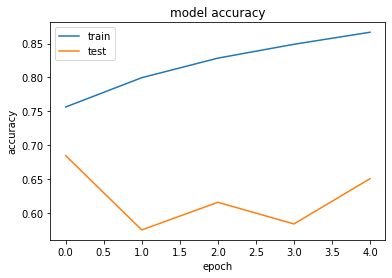

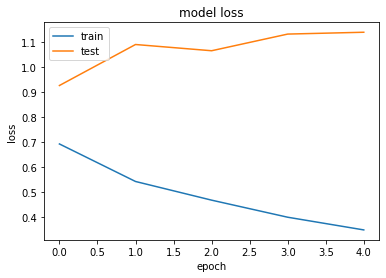

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_cnn_lstm.history['accuracy'])
plt.plot(history_cnn_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn_lstm.history['loss'])
plt.plot(history_cnn_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
## Predicting the values

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred_int = np.argmax(y_pred, axis = 1)

## Calculating the weighted score using scorer function 

In [ ]:
#Adapted from https://github.com/FakeNewsChallenge/fnc-1/blob/master/scorer.py
#Original credit - @bgalbraith

LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm


def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    print("Score",score)
    best_score, _ = score_submission(actual,actual)
    # print("best_Score",best_score)

    print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score


if __name__ == "__main__":
    actual = [0,0,0,0,1,1,0,3,3]
    predicted = [0,0,0,0,1,1,2,3,3]

    report_score([LABELS[e] for e in actual],[LABELS[e] for e in predicted])

Score 6.75
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     4     |     0     |     1     |     0     |
-------------------------------------------------------------
| disagree  |     0     |     2     |     0     |     0     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     2     |
-------------------------------------------------------------
Score: 6.75 out of 7.5	(90.0%)


In [ ]:
import sys
import numpy as np

def generate_features_new(stances,dataset,name):
    h, b, y = [],[],[]

    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])

    return y
  

competition_dataset = DataSet("competition_test")
y_competition = generate_features_new(competition_dataset.stances, competition_dataset, "competition")

Xs = dict()
ys = dict()

# Load/Precompute all features now
#Run on competition dataset
actual = [LABELS[int(a)] for a in y_competition]
predict_1= [LABELS[int(a)] for a in y_pred_int]
print(actual)
print(predict_1)

print("Scores on the test set")
report_score(actual,predict_1)

Reading dataset
Total stances: 25413
Total bodies: 904
['unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'discuss', 'unrelated', 'discuss', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'agree', 'agree', 'disagree', 'discuss', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'agree', 'unrelated', 'agree', 'unrelated', 'discuss', 'unr

46.542216500375496

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(actual,predict_1))

              precision    recall  f1-score   support

       agree       0.20      0.19      0.19      1903
    disagree       0.06      0.02      0.03       697
     discuss       0.33      0.25      0.28      4464
   unrelated       0.75      0.82      0.79     18349

    accuracy                           0.65     25413
   macro avg       0.33      0.32      0.32     25413
weighted avg       0.62      0.65      0.63     25413



In [ ]:
import pickle
with open('/content/drive/My Drive/MSCI_641/history_cnn_lstm.pkl', 'wb') as file_pi:
  pickle.dump(history_cnn_lstm.history, file_pi)